In [60]:
import datetime 
import numpy as np
import os

from google.cloud import storage
import tempfile


import tensorflow as tf



# sys.path.append("..") # Adds higher directory to python modules path.
# from drought_detection.data_handling import parse_visual_rgb, get_img_from_example


# Data Files

Connect to Google Bucket and verify TFRecord file entries look OK.

In [61]:
def dirlist(directory):
    '''list files in directory'''
    return [os.path.join(directory, file) for file in os.listdir(directory) if 'part-' in file]

In [62]:
def read_sat_file(image_file, bands_):
    '''
    This function filters satellite image data by specific spectral bands (RGB in this case).
    The function loads a batch of satellite images from a list of files
    and parses the satellite image data files for some specific features,
    e.g. spectral bands (B2, B3, B4, see official documentation)

    Input(s): - list of satellite image files (including path, e.g '/data/train/part-r-00000')
    Outputs:  - list of dictionaries of raw satellite data (filtered by spectral band)
    '''
    
    # make tfrecord format list for chosen bands
    tfrecord_format = {}
    for b in bands_:
        tfrecord_format[b] = tf.compat.v1.FixedLenFeature([], tf.string)
    tfrecord_format['label'] = tf.compat.v1.FixedLenFeature([], tf.int64)
    
    # load and parse one sat image
    dataset = tf.data.TFRecordDataset(image_file)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    parsed_sat_file = [tf.compat.v1.parse_single_example(data, tfrecord_format) for data in iterator]
    
    return parsed_sat_file


In [63]:
# function that converts a raw sat image (tensorflow object) to matrix of numbers & label (it also scales bands)
def transform_sat_img(parsed_sat_file, bands_=['B4', 'B3', 'B2'], intensify_=True):
    '''
    This function creates a 3D imgArray in shape 65 x 65 x n_bands (65x65 pixels) for
    a single parsed satellite image, while also scaling each spectral band.

    Parameters:
            parsed_sat_img (dict): a parsed satellite image: Specific Tensorflow format (as dictionary)
            bands (list): list of bands to process (order is important!)
            intensify (bool): whether to scale or not (affects how bright plotted image looks(?))

    Returns:
            imgArray (tuple): tuple of processed images in n-Dimensional arrays (depends on number of bands chosen)
            label (list): list of corresponding labels (as int32)
    '''
    # convert to image array of numbers and label
    n_bands = len(bands_) # number of of bands determines depth of imgArray
    imgArray = np.zeros((65,65,n_bands), 'uint8') # create empty array

    # transform, reshape, and intensity-scale image data
    for i, band in enumerate(bands_): # order of specified bands is important because that is the order they will be appended
        band_data = np.frombuffer(parsed_sat_file[0][band].numpy(), dtype=np.uint8) # transforms raw tensorflow data into 1D array
        band_data = band_data.reshape(65, 65) # reshapes data into 65 x 65 pixel matrix
        if intensify_:
            band_data = band_data/np.max(band_data)*255 # scaling digital numbers so image is slightly brighter
        else:
            band_data = band_data*255 # scaling digital numbers
        imgArray[..., i] = band_data

    label = tf.cast(parsed_sat_file[0]['label'], tf.int32).numpy() # gets label for image

    return imgArray, label

In [64]:
def load_img(file='../raw_data/val/part-r-00038', bands=['B4', 'B3', 'B2'], intensify=True):
    parsed_sat1 = read_sat_file(file, bands_=bands)
    imgArray, label = transform_sat_img(parsed_sat1, bands_=bands, intensify_=intensify)
    return imgArray, label

In [82]:
def load_imgs_set(directory='../raw_data/train/', n_files = 2, bands=['B4', 'B3', 'B2'], intensify=True):
    
    filenames = []
    images = []
    labels = []
    
    files = dirlist(directory)
    
    for n in range(n_files):
        imgArray, label = load_img(file=files[n], bands=bands, intensify=intensify)
        filenames.append(files[n])
        images.append(imgArray)
        labels.append(label)
        
    return filenames, images, labels

# create Prefetch dataset structure

In [ ]:
def make_prefetch_dataset(filenames, images, labels):
    '''
    This function transforms our data into the correct data structure for modelling.

    Parameters:
            filenames (list): a list of satellite files
            images (tuple): tuple of processed images in n-Dimensional arrays (depends on number of bands chosen)
            label (list): list of corresponding labels (as int32)

    Returns:
            dataset (PrefetchDataset):
                <PrefetchDataset shapes: {filename: (), image: (65, 65, 3), label: ()}, 
                types: {filename: tf.string, image: tf.uint8, label: tf.int64}>
    '''    
    AUTO = tf.data.experimental.AUTOTUNE

    dataset = tf.data.Dataset.from_tensor_slices({'filename': filenames,
                                                'image': images, 
                                                'label': labels})
    # dataset = dataset.shuffle(2048) # we shuffle later, not sure we need it here
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [83]:
filenames, images, labels = load_imgs_set(n_files = 10)
len(images), images[0].shape, labels

(10, (65, 65, 3), [0, 0, 1, 0, 0, 0, 0, 3, 0, 0])

In [85]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, images, labels))
dataset

<TensorSliceDataset shapes: ((), (65, 65, 3), ()), types: (tf.string, tf.uint8, tf.int32)>

In [96]:
labels = np.array(labels)
labels = labels.astype('int64')
type(labels[0])

numpy.int64

In [97]:
AUTO = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.from_tensor_slices({'filename': filenames,
                                              'image': images, 
                                              'label': labels})
dataset = dataset.shuffle(2048)
dataset = dataset.prefetch(AUTO)

In [98]:
dataset

<PrefetchDataset shapes: {filename: (), image: (65, 65, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>

In [68]:
# tmplist = images, labels

# np.expand_dims(tmplist, axis = 0).shape

(1, 2, 2)

In [ ]:
# tf.data.experimental.make_batched_features_dataset()

# From windspeed notebook

https://github.com/h-fuzzy-logic/python-windspeed/blob/main/Windspeed-Predictions-with-TPU.ipynb

In [7]:
# butcket data file location
BUCKET_NAME = 'wagon-data-batch913-drought_detection'
BUCKET_TRAIN_DATA_PATH = 'data/train'

# # GS bucket location path
GS_BUCKET_PATH_LINK = f"gs://{BUCKET_NAME}/{BUCKET_TRAIN_DATA_PATH}"

# check our gs bucket link
GS_BUCKET_PATH_LINK

'gs://wagon-data-batch913-drought_detection/data/train'

# works for 1 image for 1 band

In [20]:
def read_one_whole_rec(data, band='B1'):
    tfrecord_format = (
            {
            band: tf.io.FixedLenFeature([], tf.string),    # 0.43 - 0.45 μm Coastal aerosol
            'label': tf.io.FixedLenFeature([], tf.int64),
            }
        )
    data = tf.io.parse_example(data, tfrecord_format)
    img = tf.io.decode_raw(data[band], tf.uint8)
    #expecting this original image size 
    img = tf.reshape(img, [65,65,1])
    lab = data["label"]
    return img, lab


In [21]:
# get data
train_images = tf.data.TFRecordDataset(
    "gs://wagon-data-batch913-drought_detection/data/val/part-r-00000"
)
ds_train = train_images.map(read_one_whole_rec)

ds_train

<MapDataset shapes: ((65, 65, 1), ()), types: (tf.uint8, tf.int64)>

In [22]:
ds_train.take(1)

<TakeDataset shapes: ((65, 65, 1), ()), types: (tf.uint8, tf.int64)>

Windspeed is 0


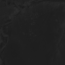

In [26]:
from PIL import Image 
import plotly.express as px

for example in ds_train.take(1):
  im, lb = example
#   print(im) # array of single band values
#   px.imshow(im) # needs 3D RGB to plot
  print("Windspeed is", str(lb.numpy())) 
  display(Image.fromarray(tf.squeeze(im).numpy())) 

In [58]:
def read_one_whole_rec(data):
  tfrecord_format = (
        {
            "x": tf.io.FixedLenFeature([], tf.string),
            "y": tf.io.FixedLenFeature([], tf.float32)
        }
   )
  
  data = tf.io.parse_example(data, tfrecord_format)
  img = tf.io.decode_raw(data["x"], tf.uint8)
  #expecting this original imgage size 
  img = tf.reshape(img, [366,366,1])
  lab = data["y"]
  return img, lab

# Train set and validation set were decided outside of this notebook.  
# Data was split by storm instead of a random split to keep a storms' images together.  
train_images = tf.data.TFRecordDataset(
    "gs://eye-speed/data/tfrecs/train.tfrecords"
)
ds_train = train_images.map(read_one_whole_rec)

val_images = tf.data.TFRecordDataset(
    "gs://eye-speed/data/tfrecs/val.tfrecords"
)
ds_val = val_images.map(read_one_whole_rec)

In [59]:

for example in ds_train.take(1):
  im, lb = example
  print("Windspeed is", str(lb.numpy())) 
  display(Image.fromarray(tf.squeeze(im).numpy())) 

PermissionDeniedError: Error executing an HTTP request: HTTP response code 403 with body '<?xml version='1.0' encoding='UTF-8'?><Error><Code>AccessDenied</Code><Message>Access denied.</Message><Details>drought-detection-service-acco@drought-detection.iam.gserviceaccount.com does not have storage.objects.get access to the Google Cloud Storage object.</Details></Error>'
	 when reading gs://eye-speed/data/tfrecs/train.tfrecords [Op:IteratorGetNext]

# try for single file, multiple bands

In [39]:
def read_one_sat_multi_bands(data):
    tfrecord_format = (
            {
            'B4': tf.io.FixedLenFeature([], tf.string),    
            'B3': tf.io.FixedLenFeature([], tf.string),  
            'B2': tf.io.FixedLenFeature([], tf.string),  
            'label': tf.io.FixedLenFeature([], tf.int64),
            }
        )
    data = tf.io.parse_example(data, tfrecord_format)
    
    b4 = tf.io.decode_raw(data['B4'], tf.uint8)
    b4 = tf.reshape(b4, [65,65,1])
    
    b3 = tf.io.decode_raw(data['B3'], tf.uint8)
    b3 = tf.reshape(b3, [65,65,1])
    
    b2 = tf.io.decode_raw(data['B2'], tf.uint8)
    b2 = tf.reshape(b2, [65,65,1])
    img = []
    img = [b4, b3, b2]
    
    #expecting this original image size 
    lab = data["label"]
    return img, lab

In [40]:
# get data
train_images = tf.data.TFRecordDataset(
    "gs://wagon-data-batch913-drought_detection/data/val/part-r-00000"
)

ds_train = train_images.map(read_one_sat_multi_bands)

ds_train

<MapDataset shapes: ((3, 65, 65, 1), ()), types: (tf.uint8, tf.int64)>

In [41]:
ds_train.take(1)

<TakeDataset shapes: ((3, 65, 65, 1), ()), types: (tf.uint8, tf.int64)>

In [56]:
# trying to loop through multiple files
file_list = ["gs://wagon-data-batch913-drought_detection/data/val/part-r-00000", 
             "gs://wagon-data-batch913-drought_detection/data/val/part-r-00001"]

ds_train = []
for f in file_list:
    train_images = tf.data.TFRecordDataset(f)
    ds_train.append(train_images.map(read_one_sat_multi_bands))
    # ds_train.append(img.take(1))

# list of MapDataset still not the right object type (also not the right shape)
ds_train

[<MapDataset shapes: ((3, 65, 65, 1), ()), types: (tf.uint8, tf.int64)>,
 <MapDataset shapes: ((3, 65, 65, 1), ()), types: (tf.uint8, tf.int64)>]

In [57]:
# still not the right object type
ds_train[1]

<MapDataset shapes: ((3, 65, 65, 1), ()), types: (tf.uint8, tf.int64)>

In [46]:
from PIL import Image 
import plotly.express as px

for example in ds_train.take(1):
  im, lb = example
#   cast_image = tf.cast(im.swapaxes(0, 3), 'float32')
  print(im) # array of single band values
#   px.imshow(im) # needs 3D RGB to plot
#   print("Windspeed is", str(lb.numpy())) 
#   display(Image.fromarray(tf.squeeze(im).numpy())) 

tf.Tensor(
[[[[53]
   [46]
   [31]
   ...
   [26]
   [27]
   [33]]

  [[50]
   [40]
   [42]
   ...
   [43]
   [40]
   [36]]

  [[44]
   [44]
   [52]
   ...
   [51]
   [57]
   [49]]

  ...

  [[65]
   [62]
   [43]
   ...
   [53]
   [49]
   [48]]

  [[65]
   [59]
   [41]
   ...
   [55]
   [50]
   [52]]

  [[59]
   [53]
   [40]
   ...
   [52]
   [55]
   [52]]]


 [[[39]
   [35]
   [30]
   ...
   [25]
   [25]
   [29]]

  [[39]
   [33]
   [35]
   ...
   [33]
   [32]
   [30]]

  [[35]
   [35]
   [39]
   ...
   [41]
   [45]
   [39]]

  ...

  [[47]
   [44]
   [33]
   ...
   [36]
   [34]
   [32]]

  [[48]
   [42]
   [32]
   ...
   [37]
   [34]
   [34]]

  [[45]
   [39]
   [32]
   ...
   [35]
   [36]
   [34]]]


 [[[35]
   [32]
   [26]
   ...
   [25]
   [26]
   [28]]

  [[34]
   [31]
   [32]
   ...
   [31]
   [30]
   [28]]

  [[33]
   [32]
   [33]
   ...
   [36]
   [38]
   [34]]

  ...

  [[39]
   [37]
   [30]
   ...
   [31]
   [30]
   [29]]

  [[40]
   [35]
   [29]
   ...
   [31]
   [30]
   [2

ValueError: px.imshow only accepts 2D single-channel, RGB or RGBA images. An image of shape (3, 65, 65, 1) was provided. Alternatively, 3- or 4-D single or multichannel datasets can be visualized using the `facet_col` or/and `animation_frame` arguments.

# scratch code

In [6]:
# does not work
read_one_whole_rec(train_images)

ValueError: Attempt to convert a value (<TFRecordDatasetV2 shapes: (), types: tf.string>) with an unsupported type (<class 'tensorflow.python.data.ops.readers.TFRecordDatasetV2'>) to a Tensor.

In [92]:
load_img(file="gs://wagon-data-batch913-drought_detection/data/train/part-r-00000")

(array([[[196, 195, 202],
         [196, 201, 202],
         [179, 183, 196],
         ...,
         [133, 154, 176],
         [133, 154, 183],
         [142, 160, 183]],
 
        [[192, 195, 202],
         [196, 201, 202],
         [192, 195, 202],
         ...,
         [146, 160, 183],
         [142, 160, 183],
         [154, 166, 189]],
 
        [[188, 189, 202],
         [192, 195, 202],
         [196, 201, 202],
         ...,
         [150, 166, 183],
         [146, 160, 183],
         [154, 166, 189]],
 
        ...,
 
        [[158, 160, 176],
         [171, 166, 183],
         [183, 171, 183],
         ...,
         [163, 177, 189],
         [150, 177, 189],
         [163, 177, 196]],
 
        [[154, 154, 176],
         [167, 160, 183],
         [179, 171, 183],
         ...,
         [154, 171, 189],
         [158, 171, 189],
         [150, 171, 189]],
 
        [[150, 154, 176],
         [154, 160, 176],
         [167, 166, 183],
         ...,
         [154, 166, 189],
  

In [44]:
ds_train.take(1)

<TakeDataset shapes: ((65, 65, 1), ()), types: (tf.uint8, tf.float32)>